#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

#Loading data

In [ ]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')

#Preprocessing

In [ ]:
print(f"train_shape: {train.shape}")
print(f"test_shape: {test.shape}")

train_shape: (1462, 5)
test_shape: (114, 5)


In [ ]:
WINDOW_SIZE = 5

In [ ]:
def data_to_input_and_output(data):

    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['meantemp'][index:index + WINDOW_SIZE]
        output_sample = data['meantemp'][index + WINDOW_SIZE]

        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data), np.array(output_data)

In [ ]:

train_input, train_output = data_to_input_and_output(train)
test_input, test_output = data_to_input_and_output(test)

#Building and traing the neural network

In [ ]:
def train_neural_network(X, y, epochs=7, learning_rate=0.005):

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # ✅ Filepath must include .keras
    check_point = ModelCheckpoint(
        filepath='model/best_model.keras',   # fixed
        save_best_only=True,
        monitor='loss',
        verbose=1
    )

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[RootMeanSquaredError()]
    )

    model.fit(X, y, epochs=epochs, callbacks=[check_point])
    return model

In [ ]:
model = train_neural_network(train_input, train_output)

Epoch 1/7
42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 543.3602 - root_mean_squared_error: 23.1952
Epoch 1: loss improved from inf to 350.24026, saving model to model/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 523.4574 - root_mean_squared_error: 22.7355
Epoch 2/7
42/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.7141 - root_mean_squared_error: 7.5939
Epoch 2: loss improved from 350.24026 to 54.36888, saving model to model/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 57.3648 - root_mean_squared_error: 7.5709
Epoch 3/7
40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.7428 - root_mean_squared_error: 5.9498
Epoch 3: loss improved from 54.36888 to 21.48911, saving model to model/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.7331 - root_mean_squared_error: 5.7661
Epoch 4/7
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0703 - root_mean_squared_error: 2.0129
Epoch 4: loss improved from 21.48911 to 3.56104, saving model to model

# Predictions

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('model/best_model.keras')


In [ ]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [ ]:
def plot_predictions(pred, y_true, label, period):
    # Convert period to datetime if it's not already
    period = pd.to_datetime(period)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', marker='o', color='black')
    plt.plot(period, pred, label='Predictions', marker='o', color='red')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Mean temperature')
    plt.title(label)

    # Adding legend
    plt.legend()

    if label == "Train Data":
        # Format X-axis to show only years
        plt.gca().xaxis.set_major_locator(YearLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    elif label == "Test Data":
        # Format X-axis to show only months
        plt.gca().xaxis.set_major_locator(MonthLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Rotate x-axis labels for better visibility
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.show()

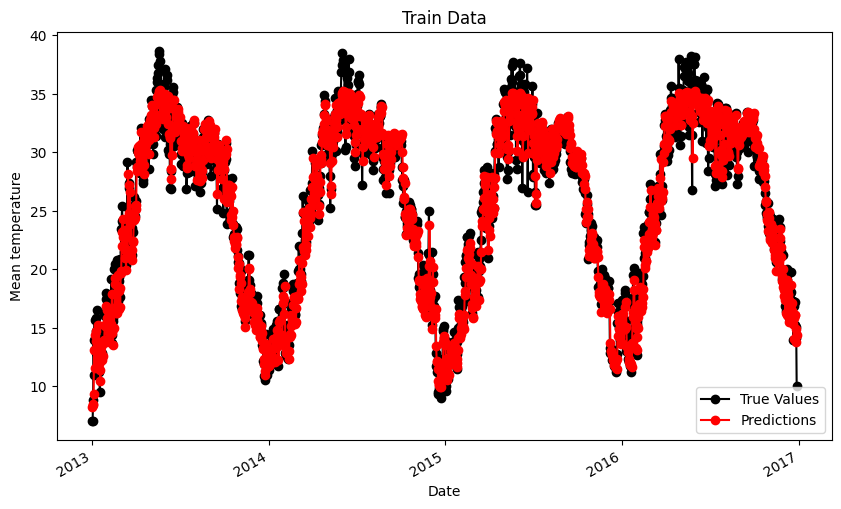

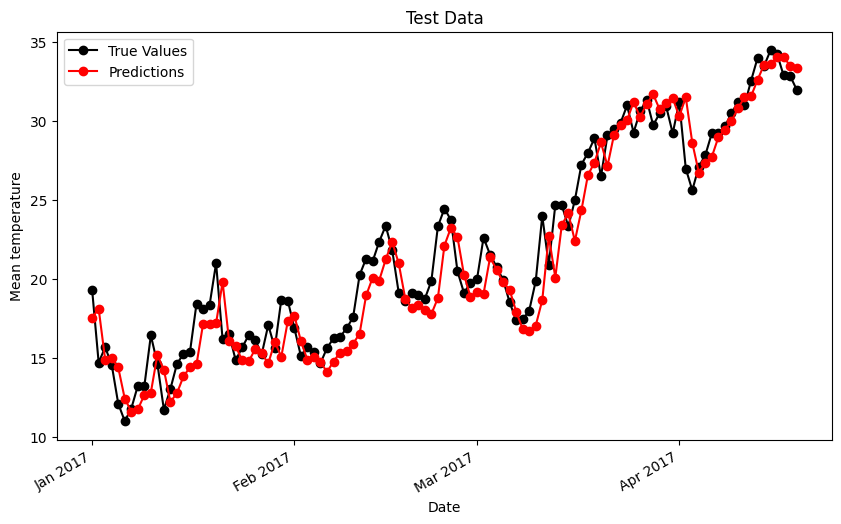

In [ ]:

train_period = train[0:len(train) - WINDOW_SIZE]['date']
test_period = test[0:len(test) - WINDOW_SIZE]['date']

plot_predictions(train_pred, train_output, 'Train Data', train_period)
plot_predictions(test_pred, test_output, 'Test Data', test_period)

# Predicting the future

In [ ]:
predictions = []

def predict_the_future(input_seq, period_prediction: int = 7):
    if period_prediction == 0:
        return None
    new_prediction = model.predict(input_seq)
    predictions.append(new_prediction[0][0])

    # input_seq = [[0], [1], [2], [3], [4]]
    # prediction = [5]
    # --> new_seq = [[1], [2], [3], [4], [5]]
    new_seq = np.array([np.concatenate((input_seq[0][1:WINDOW_SIZE], new_prediction[0]))])

    predict_the_future(new_seq, period_prediction - 1)

In [ ]:
seq_start = np.array([[15, 15.5, 16, 17, 18]])

if len(seq_start[0]) != WINDOW_SIZE:
    raise "Size mismatch"
predict_the_future(seq_start)

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[np.float32(16.886034),
 np.float32(16.074654),
 np.float32(15.390943),
 np.float32(14.88925),
 np.float32(14.365713),
 np.float32(13.913055),
 np.float32(13.522198)]